In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_theme(style='white', palette='mako')

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [2]:
date_columns = ['timestamp', 'inference_time']
categoric_columns = ['month', 'week', 'day_of_week', 'day', 'hour']
dtype_categoric = dict([(c,'category') for c in categoric_columns])

data = pd.read_csv('../../data/yellow_trip_demand_forecasting_dataset.csv', dtype=dtype_categoric, parse_dates=date_columns)

In [3]:
data

,timestamp,demand,inference_time,month,week,day_of_week,day,hour,holiday,days_since_last_holiday,...,total_trip_duration_in_last_14_days,total_trip_duration_14_days_ago,total_trip_duration_in_last_21_days,total_trip_duration_21_days_ago,total_trip_duration_in_last_28_days,total_trip_duration_28_days_ago,total_trip_duration_in_last_64_days,total_trip_duration_64_days_ago,total_trip_duration_in_last_84_days,total_trip_duration_84_days_ago
0,2011-04-02 01:00:00,13564.0,2011-03-26 01:00:00,3,12,5,26,1,False,32.083333,...,5.504969e+09,24779384.0,8.248342e+09,23043050.0,1.089616e+10,23501925.0,2.405413e+10,11469800.0,2.984548e+10,9741493.0
1,2011-04-02 02:00:00,11691.0,2011-03-26 02:00:00,3,12,5,26,2,False,32.125000,...,5.496142e+09,20543462.0,8.241251e+09,19148496.0,1.088861e+10,18277849.0,2.405861e+10,7596900.0,2.985169e+10,11434865.0
2,2011-04-02 03:00:00,9062.0,2011-03-26 03:00:00,3,12,5,26,3,False,32.166667,...,5.487776e+09,16241588.0,8.234280e+09,15042869.0,1.088250e+10,15318922.0,2.406319e+10,5575315.0,2.985243e+10,9972823.0
3,2011-04-02 04:00:00,5966.0,2011-03-26 04:00:00,3,12,5,26,4,False,32.208333,...,5.479787e+09,12494689.0,8.227490e+09,11962838.0,1.087544e+10,12032291.0,2.406587e+10,3933576.0,2.985071e+10,8293949.0
4,2011-04-02 05:00:00,2970.0,2011-03-26 05:00:00,3,12,5,26,5,False,32.250000,...,5.471432e+09,8392333.0,8.219666e+09,7182925.0,1.086755e+10,7732448.0,2.406608e+10,3153603.0,2.984655e+10,5934715.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102251,2022-11-30 19:00:00,7290.0,2022-11-23 19:00:00,11,47,2,23,19,False,11.833333,...,1.667148e+09,8066985.0,2.686725e+09,8592846.0,3.631767e+09,8643716.0,8.278548e+09,8286756.0,1.058132e+10,6066895.0
102252,2022-11-30 20:00:00,6897.0,2022-11-23 20:00:00,11,47,2,23,20,False,11.875000,...,1.663896e+09,6632357.0,2.682948e+09,7387364.0,3.627938e+09,7226851.0,8.275077e+09,7141187.0,1.058006e+10,5618919.0
102253,2022-11-30 21:00:00,7023.0,2022-11-23 21:00:00,11,47,2,23,21,False,11.916667,...,1.662336e+09,7207900.0,2.680632e+09,6693895.0,3.625783e+09,7598060.0,8.273007e+09,6582788.0,1.057952e+10,5107744.0
102254,2022-11-30 22:00:00,6380.0,2022-11-23 22:00:00,11,47,2,23,22,False,11.958333,...,1.659248e+09,6129690.0,2.678059e+09,6071933.0,3.622306e+09,6725626.0,8.270545e+09,5758059.0,1.057853e+10,5266510.0


In [4]:
train_start_date = data['inference_time'].min()
train_end_date = data['inference_time'].min() + pd.DateOffset(months=15)
test_end_date = train_end_date + pd.DateOffset(months=3)
prod_end_date = data['inference_time'].max()

# Create data partition
data['partition'] = pd.cut(
    data['inference_time'],
    bins= [train_start_date,
           train_end_date,
           test_end_date,
           prod_end_date],
    right=False,
    labels= ['train', 'test', 'prod']
)

# Set target and features
target = 'demand'
features = [col for col in data.columns if col not in [target, 'partition'] + date_columns]

# Split the data
X_train = data.loc[data['partition'] == 'train', features]
y_train = data.loc[data['partition'] == 'train', target]

X_test = data.loc[data['partition'] == 'test', features]
y_test = data.loc[data['partition'] == 'test', target]

X_prod = data.loc[data['partition'] == 'prod', features]
y_prod = data.loc[data['partition'] == 'prod', target]

## Exploring the training data

In [5]:
df = data.loc[data['partition'] == 'train', ['timestamp', 'demand']]
df['day'] = df['timestamp'].dt.to_period('D')

df1 = df.copy()
df1 = df1.groupby(['day'])['demand'].sum() / 1e3
df1.index = df1.index.to_timestamp()
df1 = df1.reset_index()
df1['day_of_week'] = df1['day'].dt.dayofweek + 1
df1['month'] = df1['day'].dt.month


In [6]:
df1['demand'].median()

485.995

In [7]:
pd.qcut(df1['demand'], q=4)

0        (12.13, 449.314]
1        (12.13, 449.314]
2      (449.314, 485.995]
3      (520.244, 587.917]
4      (485.995, 520.244]
              ...        
454    (520.244, 587.917]
455    (449.314, 485.995]
456      (12.13, 449.314]
457      (12.13, 449.314]
458      (12.13, 449.314]
Name: demand, Length: 459, dtype: category
Categories (4, interval[float64, right]): [(12.13, 449.314] < (449.314, 485.995] < (485.995, 520.244] < (520.244, 587.917]]

In [8]:
df1

,day,demand,day_of_week,month
0,2011-04-02,263.183,6,4
1,2011-04-03,240.633,7,4
2,2011-04-04,458.737,1,4
3,2011-04-05,525.459,2,4
4,2011-04-06,515.766,3,4
...,...,...,...,...
454,2012-06-29,532.261,5,6
455,2012-06-30,480.846,6,6
456,2012-07-01,424.112,7,7
457,2012-07-02,409.243,1,7


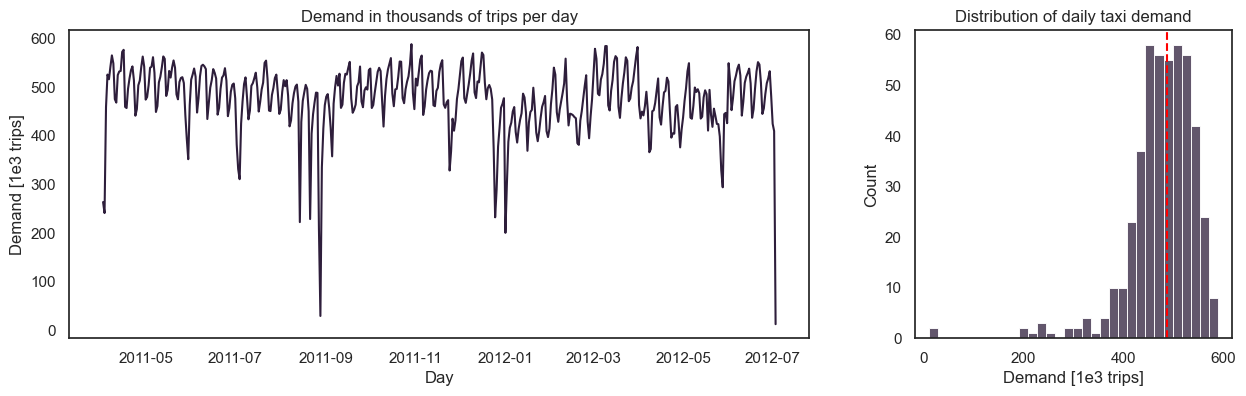

In [9]:
fig, ax = plt.subplots(1, 2, width_ratios=[70, 30], figsize=(15, 4))

sns.lineplot(data=df1, x='day', y='demand', ax=ax[0])
ax[0].set_title('Demand in thousands of trips per day')
ax[0].set_ylabel('Demand [1e3 trips]')
ax[0].set_xlabel('Day')

sns.histplot(data=df1, x='demand', ax=ax[1])
plt.axvline(df1['demand'].median(), color='r', linestyle='--')
ax[1].set_title('Distribution of daily taxi demand')
ax[1].set_xlabel('Demand [1e3 trips]')
plt.savefig('../../figures/taxi_demand_timeseries_and_distribution.svg', format='svg', bbox_inches='tight')
plt.show()

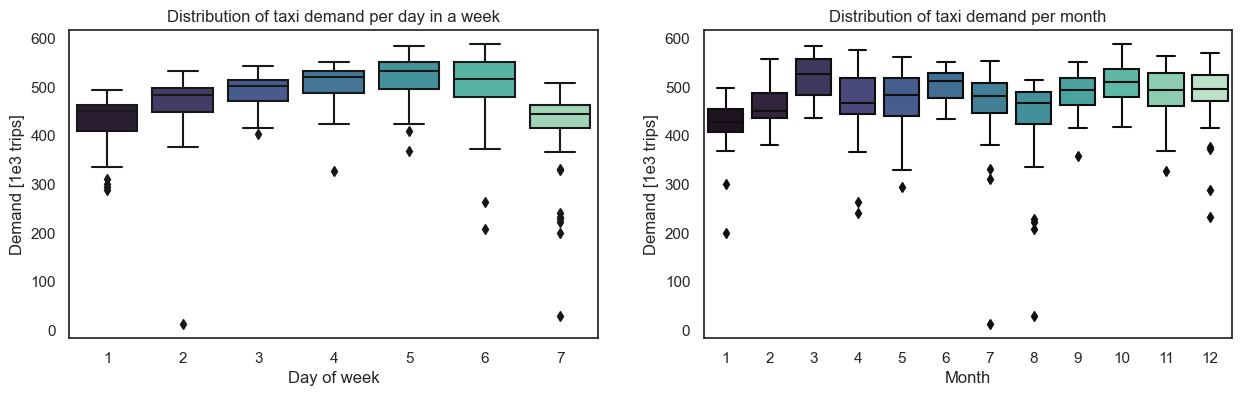

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(15,4))
sns.boxplot(data=df1, x='day_of_week', y='demand', ax=ax[0], palette='mako')
ax[0].set_title('Distribution of taxi demand per day in a week')
ax[0].set_xlabel('Day of week')
ax[0].set_ylabel('Demand [1e3 trips]')

sns.boxplot(data=df1, x='month', y='demand', order=[i for i in range(1, 13)], ax=ax[1], palette='mako')
ax[1].set_title('Distribution of taxi demand per month')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Demand [1e3 trips]')
plt.savefig('../../figures/taxi_day_month_demand.svg', format='svg', bbox_inches='tight')
plt.show()

In [11]:
df2 = data.loc[data['partition'] == 'train']
df2 = df2[['timestamp', 'holiday']]
df2['day'] = df2['timestamp'].dt.to_period('D').dt.to_timestamp()
df2 = df2.drop(columns='timestamp').drop_duplicates()

In [12]:
df3 = df1.merge(df2, how='left', on='day')

In [13]:
df3

,day,demand,day_of_week,month,holiday
0,2011-04-02,263.183,6,4,False
1,2011-04-03,240.633,7,4,False
2,2011-04-04,458.737,1,4,False
3,2011-04-05,525.459,2,4,False
4,2011-04-06,515.766,3,4,False
...,...,...,...,...,...
454,2012-06-29,532.261,5,6,False
455,2012-06-30,480.846,6,6,False
456,2012-07-01,424.112,7,7,False
457,2012-07-02,409.243,1,7,False


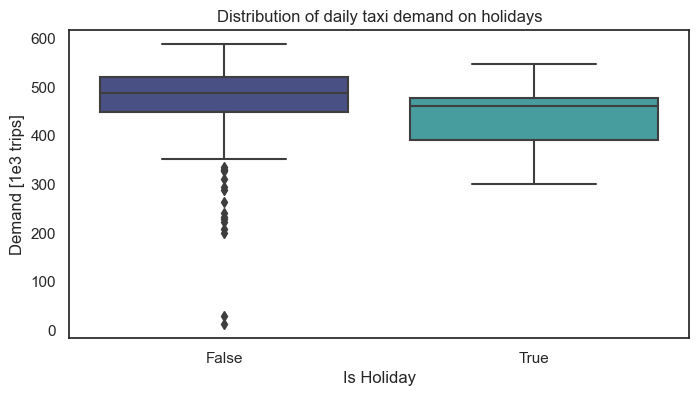

In [14]:
fig, ax = plt.subplots(figsize=(8,4))
sns.boxplot(data=df3, x='holiday', y='demand', ax=ax, palette='mako')
ax.set_title('Distribution of daily taxi demand on holidays')
ax.set_ylabel('Demand [1e3 trips]')
ax.set_xlabel('Is Holiday')
plt.savefig('../../figures/taxi_day_holiday_demand.svg', format='svg', bbox_inches='tight')
plt.show()

## Train a model

In [15]:
from lightgbm import LGBMRegressor, plot_importance
model = LGBMRegressor(random_state=111)
model.fit(X_train, y_train)

LGBMRegressor(random_state=111)

In [16]:
# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

## Evaluate the model

In [17]:
# Make baseline predictions
y_pred_train_baseline = np.ones_like(y_train) * y_train.mean()
y_pred_test_baseline = np.ones_like(y_test) * y_train.mean()

# Measure train, test and baseline performance
mape_train = mean_absolute_percentage_error(y_train, y_pred_train).round(4)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test).round(4)

mape_train_baseline = mean_absolute_percentage_error(y_train, y_pred_train_baseline).round(4)
mape_test_baseline = mean_absolute_percentage_error(y_test, y_pred_test_baseline).round(4)

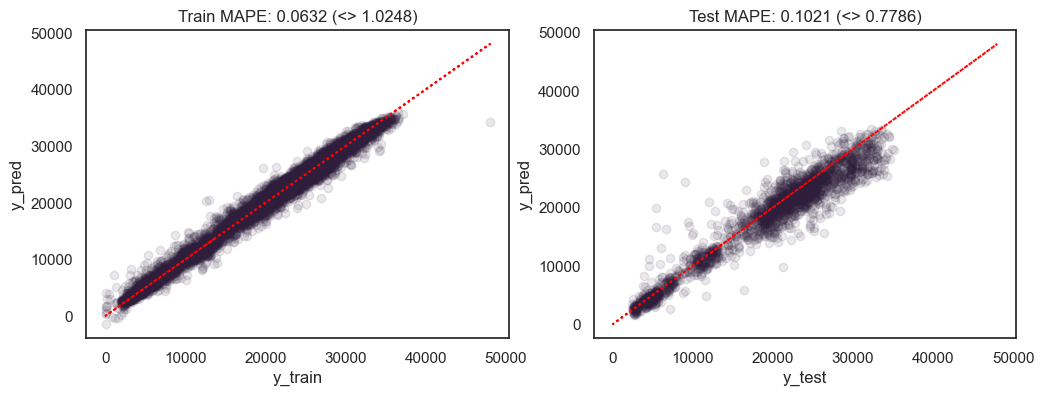

In [18]:
# Create performance report 
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,4))

upper_lim = max(y_train.max(), y_test.max(), y_pred_train.max(), y_pred_test.max())

title1 = 'Train MAPE: {} (<> {})'.format(mape_train, mape_train_baseline) 
ax1.set(title=title1, xlabel='y_train', ylabel='y_pred')
ax1.plot(y_train, y_train, color='red', linestyle=':')
ax1.scatter(y_train, y_pred_train, alpha=0.1)
# ax1.set_xlim(0, upper_lim)
# ax1.set_ylim(0, upper_lim)

title2 = 'Test MAPE: {} (<> {})'.format(mape_test, mape_test_baseline)
ax2.set(title=title2, xlabel='y_test', ylabel='y_pred')
ax2.plot(y_train, y_train, color='red', linestyle=':')
ax2.scatter(y_test, y_pred_test, alpha=0.1)
ax2.set
# ax2.set_xlim(0, upper_lim)
# ax2.set_ylim(0, upper_lim)

plt.savefig('../../figures/taxi_model_plots.svg', format='svg', bbox_inches='tight')
plt.show()

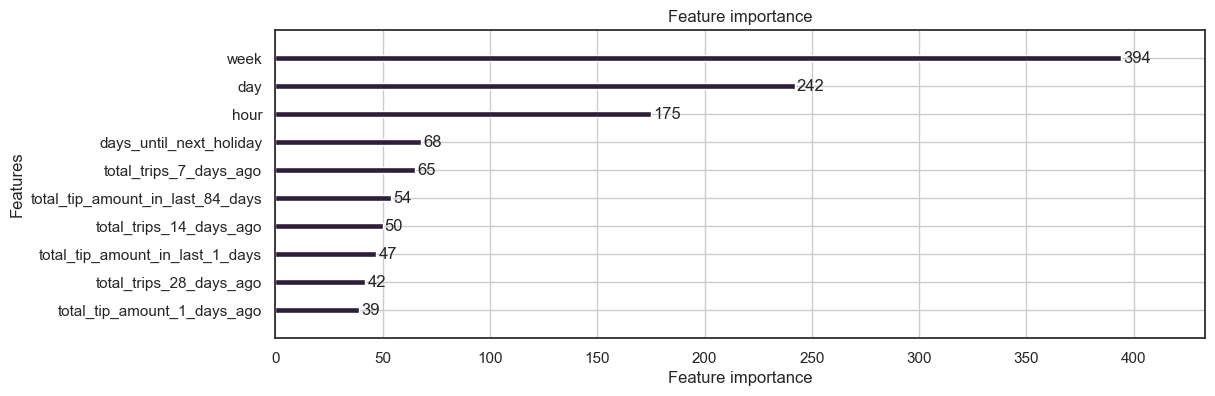

In [19]:
fig, ax = plt.subplots(figsize=(12,4))
a = plot_importance(model, ax=ax, max_num_features=10)
# plt.savefig('fig_2.png', dpi=300)
plt.savefig('../../figures/taxi_model_feature_importance.svg', format='svg', bbox_inches='tight')
plt.show()

## Making predictions

In [20]:
data['predicted_demand'] = model.predict(data[features])

## Post-deployment model analysis

In [21]:
def vspan(ax, ax2=None):
    handles, labels = ax.get_legend_handles_labels()
    
    if len(handles) > 3:
        handles = handles[:2]
        labels = labels[:2]
    else:
        handles = handles[:1]
        labels = labels[:1]
    
    if ax2:
        handles2, labels2 = ax2.get_legend_handles_labels()
        handles2 = handles2[1]
        labels2 = labels2[1]
        
        handles = handles + [handles2]
        labels = labels + ['mean_absolute_error']

    ax.axvspan(train_start_date, train_end_date, color='#44AF69', alpha=0.25, zorder=-10)
    legend_patch = mpatches.Patch(color='#44AF69', alpha=0.25, label='Train')
    handles.append(legend_patch)
    labels.append('Train')

    ax.axvspan(train_end_date, test_end_date, color='#F2DC5D', alpha=0.125, zorder=-10)
    legend_patch = mpatches.Patch(color='#F2DC5D', alpha=0.125, label='Test')
    handles.append(legend_patch)
    labels.append('Test')

    ax.legend(handles=handles, labels=labels)

In [22]:
df = data[['timestamp', 'demand', 'predicted_demand']].copy()
df['month'] = df['timestamp'].dt.to_period('M')
df['week'] = df['timestamp'].dt.to_period('W')

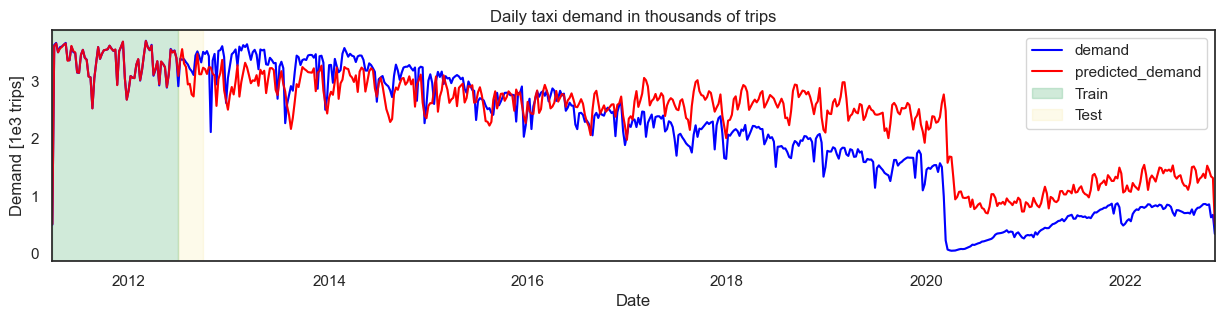

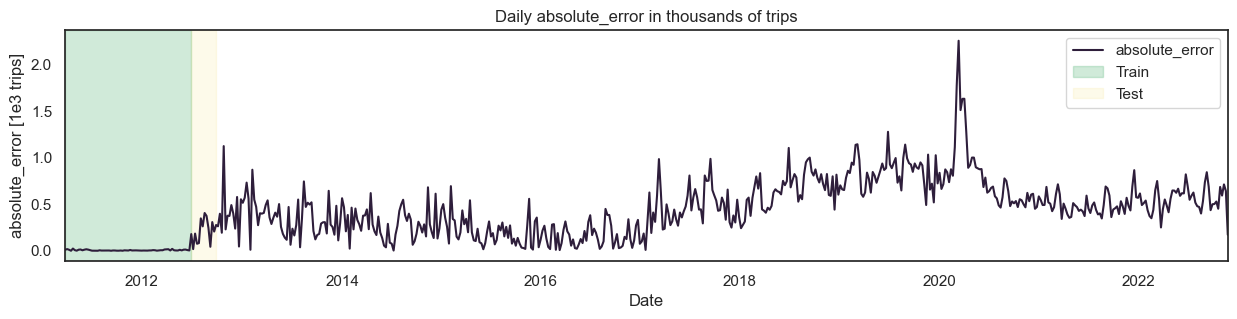

In [23]:
daily_demand = df.groupby('week')[['demand', 'predicted_demand']].sum() / 1000000
daily_demand['absolute_error'] = (daily_demand['demand'] - daily_demand['predicted_demand']).abs()
daily_demand.index = daily_demand.index.to_timestamp()

fig, ax = plt.subplots(figsize=(15, 3))
ax.set_title('Daily taxi demand in thousands of trips')
daily_demand[['demand', 'predicted_demand']].rolling(window=1).mean().plot(ax=ax, color=['blue', 'red'])
daily_demand[['demand', 'predicted_demand']].plot(ax=ax, alpha=0.125, legend=False, color=['blue', 'red'])
vspan(ax)
ax.set(xlabel='Date', ylabel='Demand [1e3 trips]')
plt.savefig('../../figures/taxi_true_demand_vs_predicted_timeseries.svg', format='svg', bbox_inches='tight')


fig, ax = plt.subplots(figsize=(15, 3))
ax.set_title('Daily absolute_error in thousands of trips')
daily_demand[['absolute_error']].plot(ax=ax, legend=False)
ax.set(xlabel='Date', ylabel='absolute_error [1e3 trips]')

vspan(ax)
plt.savefig('../../figures/taxi_weekly_absolute_error_timeseries.svg', format='svg', bbox_inches='tight')
plt.show()